In [1]:
%load_ext autoreload
%autoreload 2

# from 1dgp
import os
import sys
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

#from VAE,piVAE
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.nn.parameter import Parameter
from tqdm import tqdm, trange
import cmdstanpy
import pandas as pd
import pickle
import math


/home/shug7409/.conda/envs/basic/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GP1D(Dataset):
    def __init__(self, dataPoints=100, samples=10000, ingrid=True, x_lim = 1,
                        seed=np.random.randint(20), kernel='rbf',ls = 0.1, nu=2.5):
        self.dataPoints = dataPoints
        self.samples = samples
        self.ingrid = ingrid
        self.x_lim = x_lim
        self.seed = seed
        self.Max_Points = 2 * dataPoints
        self.ls = ls
        self.nu = nu
        self.kernel = kernel
        np.random.seed(self.seed)
        self.evalPoints, self.data = self.__simulatedata__()
    
    def __len__(self):
        return self.samples
    
    def __getitem__(self, idx=0):
        return(self.evalPoints[:,idx], self.data[:,idx])


    def __simulatedata__(self):
        if self.kernel=='rbf':
            gp = GaussianProcessRegressor(kernel=RBF(length_scale=self.ls))
        elif self.kernel=='matern':
            gp = GaussianProcessRegressor(kernel=Matern(length_scale=self.ls, nu=self.nu))
        else:
            return None
        if (self.ingrid):
            X_ = np.linspace(-self.x_lim, self.x_lim, self.dataPoints)
            y_samples = gp.sample_y(X_[:, np.newaxis], self.samples)
            # print(X_.shape, y_samples.shape)
            return (X_.repeat(self.samples).reshape(X_.shape[0],self.samples) ,
                        y_samples)
        else:
            X_ = np.linspace(-self.x_lim, self.x_lim, self.Max_Points)
            X_ = np.random.choice(X_, (self.dataPoints,self.samples))
            X_.sort(axis=0)
            y_samples = np.zeros((self.dataPoints,self.samples))
            for idx in range(self.samples):
                x_ = X_[:,idx]
                y_samples[:,idx] = gp.sample_y(x_[:, np.newaxis]).reshape(self.dataPoints,)
            # print(X_.shape, y_samples.shape)
            return (X_, y_samples)

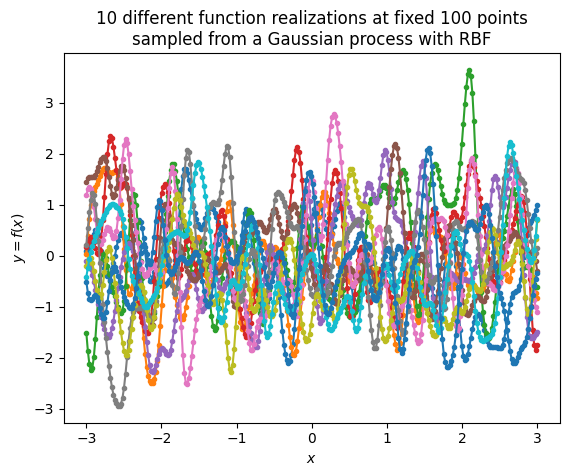

In [3]:
def visualize_1D_gp():
    dataset =GP1D(dataPoints=300, samples=10000, ls=0.1, x_lim=3)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for no, dt in enumerate(dataloader):
        ax.plot(dt[0].reshape(-1,1), dt[1].reshape(-1,1), marker='o', markersize=3)
        if no > 9: break
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y=f(x)$')
    ax.set_title('10 different function realizations at fixed 100 points\n'
    'sampled from a Gaussian process with RBF')
    plt.savefig('plots/sample_prior_gp_1d_fixed.pdf')
visualize_1D_gp()

In [4]:
class PHI(nn.Module):
    '''
    Implementation of feature transformation layer with RBF layer.
    We assume here that alpha is constant for all basis.
    Shape:
        - Input: (N, n_evals, in_features) N is batches
        - Output: (N, n_evals, out_dims), out_dims is a parameter
    Parameters:
        - in_features: number of input dimension for each eval point
        - alpha - trainable parameter controls width. Default is 1.0
        - n_centers - number of points to be used as centers in rbf/matern
        layers. centers are trainable, default is 100
        - hidden_dim1: hidden dimension for 1st layer. Default is 20
        - hidden_dim2: hidden dimension for 2nd layer. Default is 20
        - out_dims: output features to construct. Default is 100
    Examples:
        >>> a1 = PHI(256)
        >>> x = torch.randn(1,256)
        >>> x = a1(x)
    '''
    def __init__(self, in_features, alpha = 1.0, n_centers = 10, 
                    hidden_dim1 = 20, hidden_dim2 = 20, out_dims = 100):
        '''
        Initialization.
        INPUT:
            - in_features: number of input dimension for each eval point
            - alpha: trainable parameter
            alpha is initialized with 1.0 value by default
            - n_centers: number of points to be used as centers in rbf/matern
            layers. centers are trainable, default is 100
            - hidden_dim1: hidden dimension for 1st layer. Default is 20
            - hidden_dim2: hidden dimension for 2nd layer. Default is 20
            - out_dims: hidden dimension for 2nd layer. Default is 100
        '''
        super(PHI,self).__init__()
        self.in_features = in_features

        # initialize alpha
       # self.alpha = Parameter(torch.tensor(alpha)) # create a tensor out of alpha
        print("here2")
        #self.alpha.requiresGrad = True # set requiresGrad to true!
        # centers
        self.centers = Parameter(torch.randn(n_centers, in_features)) # create a tensor out of centers
        self.centers.requiresGrad = True # set requiresGrad to true!
        # linear layers
        self.linear1 = nn.Linear(n_centers, hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.out = nn.Linear(hidden_dim2, out_dims)

    def forward(self, x):
        '''
        Forward pass of the function.
        Applies the function to the input elementwise.
        '''
        rbf = torch.exp(-1 * torch.cdist(x, self.centers).pow(2))
        hidden1 = torch.tanh(self.linear1(rbf))
        hidden2 = torch.tanh(self.linear2(hidden1))
        out = self.out(hidden2)
        return out

In [5]:
class Encoder(nn.Module):
    ''' This the encoder part of VAE
    '''
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, z_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.mu = nn.Linear(hidden_dim2, z_dim)
        self.sd = nn.Linear(hidden_dim2, z_dim)
    def forward(self, x):
        # x is of shape [batch_size, input_dim]
        hidden1 = torch.tanh(self.linear1(x))
        # hidden1 is of shape [batch_size, hidden_dim1]
        hidden2 = torch.tanh(self.linear2(hidden1))
        # hidden2 is of shape [batch_size, hidden_dim2]
        z_mu = self.mu(hidden2)
        # z_mu is of shape [batch_size, z_dim]
        z_sd = self.sd(hidden2)
        # z_sd is of shape [batch_size, z_dim]
        return z_mu, z_sd

class Decoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self,z_dim, hidden_dim1, hidden_dim2, input_dim):
        super().__init__()
        self.linear1 = nn.Linear(z_dim, hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.out = nn.Linear(hidden_dim2, input_dim)
    def forward(self, x):
        # x is of shape [batch_size, z_dim]
        hidden1 = torch.tanh(self.linear1(x))
        # hidden1 is of shape [batch_size, hidden_dim1]
        hidden2 = torch.tanh(self.linear2(hidden1))
        # hidden2 is of shape [batch_size, hidden_dim2]
        pred = self.out(hidden2)
        # pred is of shape [batch_size, input_dim]
        return pred

class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.
    '''
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim1, hidden_dim2, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim1, hidden_dim2, input_dim)

    def reparameterize(self, z_mu, z_sd):
        '''During training random sample from the learned ZDIMS-dimensional
           normal distribution; during inference its mean.
        '''
        if self.training:
            # sample from the distribution having latent parameters z_mu, z_sd
            # reparameterize
            std = torch.exp(z_sd / 2)
            eps = torch.randn_like(std)
            return (eps.mul(std).add_(z_mu))
        else:
            return z_mu


    def forward(self, x):
        # encode
        z_mu, z_sd = self.encoder(x)
        # reparameterize
        x_sample = self.reparameterize(z_mu, z_sd)
        # decode
        generated_x = self.decoder(x_sample)
        return generated_x, z_mu,z_sd

def calculate_loss_VAE(x, reconstructed_x, mean, log_sd):
    # reconstruction loss
    RCL = F.mse_loss(reconstructed_x, x, reduction='sum')
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + log_sd - mean.pow(2) - log_sd.exp())
    return RCL + KLD

In [6]:
class PIVAE(nn.Module):
    '''
    Implementation of PIVAE with feature transformation layer (RBF layer).
    Shape:
        - Input: (N, n_evals, in_features) N is batches
        - Output: (N, n_evals, 1), currently we have 1D output only
    Parameters:
        - in_features: number of input dimension for each eval point
        - alpha - trainable parameter controls width. Default is 1.0
        - n_centers - number of points to be used as centers in rbf/matern
        layers. centers are trainable, default is 100
        - dim1: hidden dimension for 1st transformation layer. Default is 20
        - dim2: hidden dimension for 2nd layer. Default is 20
        - out_dims: output features to construct (size of beta and VAE). 
        Default is 100
        - hidden_dim1 - hidden dimensions for 1st layer VAE. Default is 128
        - hidden_dim2 - hidden dimensions for 1st layer VAE. Default is 64
        - z_dim - latent dimension for VAE. Default is 20
        - batch_size - batch_size for training. For now set same as n_samples
    Examples:
        >>> a1 = PHI(256)
        >>> x = torch.randn(1,256)
        >>> x = a1(x)
    '''
    def __init__(self, in_features, alpha = 1.0, n_centers = 10, dim1 = 20, 
                    dim2 = 20, out_dims = 100, hidden_dim1 = 128, 
                    hidden_dim2 = 64, z_dim = 20, batch_size = 10000):
        super(PIVAE, self).__init__()
        self.out_dims = out_dims
        self.batch_size = batch_size
        self.phi = PHI(in_features, alpha=alpha, n_centers=n_centers, 
                        hidden_dim1=dim1, hidden_dim2=dim2, out_dims=out_dims)
        self.betas = nn.ModuleList()
        for _ in range(self.batch_size):
            self.betas.append(nn.Linear(out_dims, 1))
        self.vae = VAE(input_dim=out_dims, hidden_dim1=hidden_dim1, 
                        hidden_dim2=hidden_dim2, latent_dim=z_dim)
    
    def forward(self, x):
        '''
        Forward pass of the function.
        Applies the function to the input elementwise.
        '''        
        phi_x = self.phi(x)
        y1 = torch.stack([self.betas[i](phi_x[i]) for i in range(self.batch_size)
                            ]).flatten(1)
        beta = torch.stack([self.betas[i].weight for i in range(self.batch_size)
                            ]).flatten(0,1)
        beta_vae = self.vae(beta)
        y2 = torch.stack([phi_x[i]@beta_vae[0][i] + self.betas[i].bias for i in 
                            range(self.batch_size)])
        return y1, y2, beta_vae[1], beta_vae[2]
    
def calculate_loss(target, reconstructed1, reconstructed2, mean, log_var):
    # reconstruction loss
    RCL = F.mse_loss(reconstructed1, target, reduction='sum') + \
                F.mse_loss(reconstructed2, target, reduction='sum')
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RCL + KLD

In [7]:
def train_piVAE():
    # Just showing how to use piVAE to learn priors

    ###### intializing data and model parameters
    n_samples = 1000
    in_features = 1
    n_evals = 1000
    n_centers = math.ceil(n_evals/2)
    alpha = 1.0
    dim1 = 20
    dim2 = 20
    hidden_dims1 = 16
    hidden_dims2 = 8
    z_dim = 5
    out_dims = 10
    batch_size = 5

    ###### creating data, model and optimizer
    train_ds = GP1D(dataPoints=n_evals, samples=n_samples, ls=0.1)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    model = PIVAE(in_features=in_features, alpha=alpha, n_centers=n_centers,
                     dim1=dim1, dim2=dim2, out_dims=out_dims, 
                     hidden_dim1=hidden_dims1, hidden_dim2=hidden_dims2, 
                     z_dim=z_dim, batch_size=batch_size)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    model = model.to(device)

    print(device)
    ###### running for 1000 epochs
    t = trange(1000)
    for e in t:
        # set training mode
        model.train()
        total_loss = 0
        for i,x in enumerate(train_dl):
            target = x[1].float().to(device)
            # target = target.view(target.shape[0], target.shape[1], 1)
            x = x[0].float().to(device)
            x = x.view(x.shape[0], x.shape[1], 1)
            optimizer.zero_grad()   # zero the gradient buffers
            y1, y2, z_mu, z_sd = model(x) # fwd pass
            loss = calculate_loss(target, y1, y2, z_mu, z_sd) # loss cal
            loss.backward() # bck pass
            total_loss += loss.item() 
            optimizer.step() # update the weights
        t.set_description(f'Loss is {total_loss/(n_evals*n_samples):.3}')
    
    return model

In [ ]:
model,losses = train_piVAE()

here2
cpu


Loss is 2.04:  31%|█████████████████████                                                | 306/1000 [53:36<2:02:13, 10.57s/it]

In [ ]:
# phi = PHI(1, alpha=1.0, n_centers=1000, hidden_dim1=20, hidden_dim2=20, out_dims=10)
phi = model.phi
phi.eval()

In [ ]:
# vae = VAE(input_dim=10, hidden_dim1=16, hidden_dim2=8, latent_dim=5)
vae = model.vae
vae_decoder = vae.decoder

In [ ]:
# sampling points to evaluate functions values
x_inf = np.linspace(-10,10,60).reshape(-1,1)
e_n = 9 * np.random.randn(60).reshape(-1,1)
y_ = np.power(x_inf,3) 
y_inf = np.power(x_inf,3) + e_n
idx = (x_inf>=-2) * (x_inf<=2)
ll_idx = np.where(idx)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_inf, y_, color='blue', alpha=0.5)
ax.scatter(x_inf[ll_idx], y_inf[ll_idx], marker='+', color='red', alpha=0.5, s=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')

In [ ]:
stan_data = {'p': 5, 
                 'p1': 16,
                 'p2': 8,
                 'n': 60,
                 'W1': vae_decoder.linear1.weight.T.detach().numpy(),
                 'B1': vae_decoder.linear1.bias.T.detach().numpy(),
                 'W2': vae_decoder.linear2.weight.T.detach().numpy(),
                 'B2': vae_decoder.linear2.bias.T.detach().numpy(),
                 'W3': vae_decoder.out.weight.T.detach().numpy(),
                 'B3': vae_decoder.out.bias.T.detach().numpy(),
                 'beta_dim' : 10,
                 'phi_x' : phi(torch.tensor(x_inf).float()).detach().numpy(),
                 'y': y_inf.reshape(60,),
                 'll_len' : ll_idx[0].shape[0],
                 'll_idxs' : ll_idx[0]}

In [ ]:
sm = cmdstanpy.CmdStanModel(stan_file='../notebooks/pivae.stan')

In [ ]:
fit = sm.sample(data=stan_data, iter_sampling=2000, iter_warmup=500, chains=4)

In [ ]:
out = fit.stan_variables()

df = pd.DataFrame(out['y2'])

In [ ]:
datapoints = x_inf
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(datapoints, y_, color='black', label='True')
ax.scatter(datapoints[ll_idx], y_inf[ll_idx], s=46,label = 'Observations')
ax.fill_between(datapoints.reshape(datapoints.shape[0]), df.quantile(0.025).to_numpy(), df.quantile(0.975).to_numpy(),
                    facecolor="blue",
                    color='blue', 
                    alpha=0.2, label = '95% Credible Interval') 
ax.plot(datapoints, df.mean().to_numpy().reshape(-1,1), color='red', alpha=0.7, label = 'Posterior mean')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Inference fit')
ax.legend()